In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
from sjireader import read_iris_sji
import eispac
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
from datetime import datetime

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


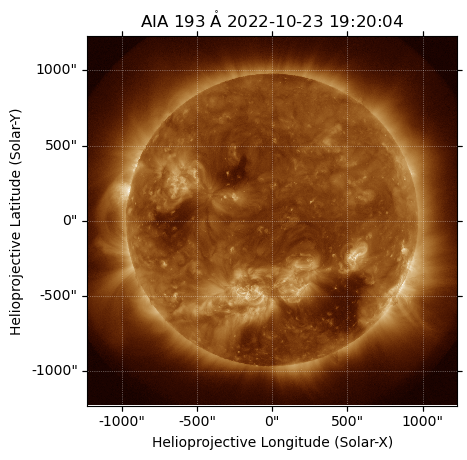

In [2]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221023/193/lvl15/aia.lev1_euv_12s.2022-10-23T192003Z.193.image.fits")
aia_193_map.plot()

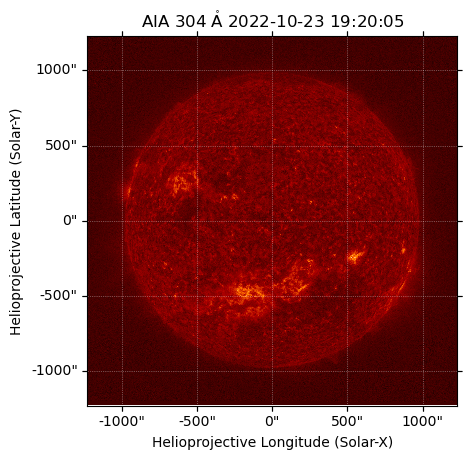

In [3]:
aia_304_map = sunpy.map.Map("../../src/AIA/20221023/304/lvl15/aia.lev1_euv_12s.2022-10-23T192003Z.304.image.fits")
aia_304_map.plot()

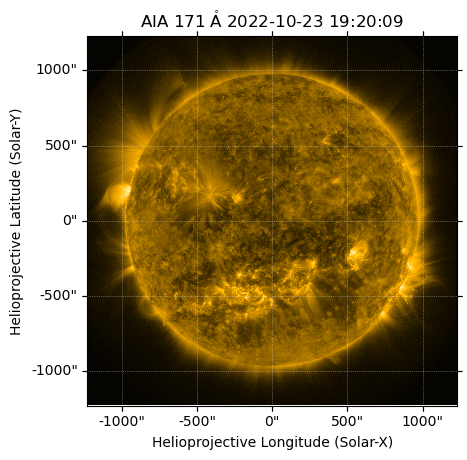

In [4]:
aia_171_map = sunpy.map.Map("../../src/AIA/20221023/171/lvl15/aia.lev1_euv_12s.2022-10-23T192015Z.171.image.fits")
aia_171_map.plot()

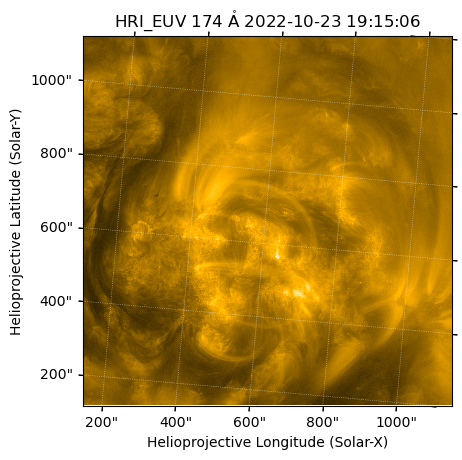

In [6]:
hri_174_map = sunpy.map.Map("../../src/EUI/HRI/euv174/20221023/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits")
hri_174_map.meta["rsun_ref"] = 696000000.
hri_174_map.plot()

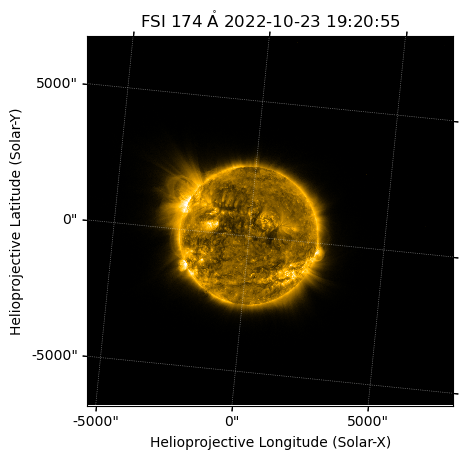

In [7]:
fsi_174_map = sunpy.map.Map("../../src/EUI/FSI/euv174/20221023/solo_L2_eui-fsi174-image_20221023T192050276_V01.fits")
fsi_174_map.meta["rsun_ref"] = 696000000.
fsi_174_map.plot()

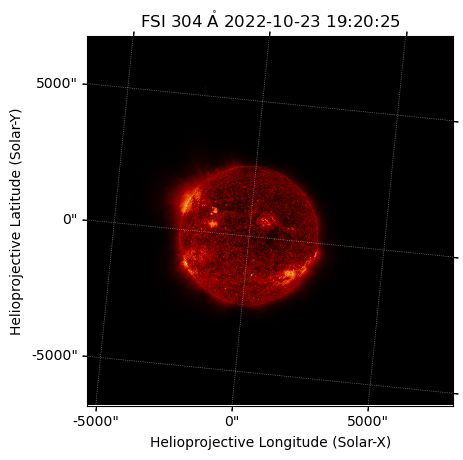

In [8]:
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221023/solo_L2_eui-fsi304-image_20221023T192020276_V01.fits")
fsi_304_map.meta["rsun_ref"] = 696000000.
fsi_304_map.plot()

In [9]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

In [10]:
def derotate_fsi(fsi_map, hri_map,algorithm="adaptive"):
    out_frame = hri_map.coordinate_frame
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(fsi_map.data.shape,
                                        out_center,
                                        scale=u.Quantity(fsi_map.scale),
                                        rotation_matrix=hri_map.rotation_matrix) 
    # correct the tiny rotation matrix difference between FSI and HRI, which simply the coalignment
    out_wcs = WCS(header)

    with propagate_with_solar_surface():
        fsi_map_derot = fsi_map.reproject_to(out_wcs,algorithm=algorithm)

    return fsi_map_derot


In [11]:
fsi_174_map_hri_time = derotate_fsi(fsi_174_map,hri_174_map)

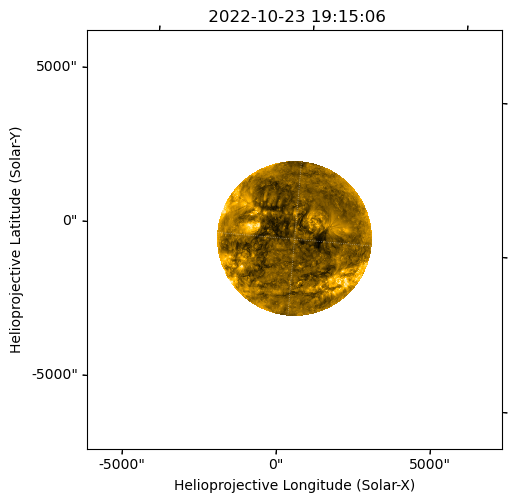

In [12]:
fig = plt.figure(figsize=(5,5),constrained_layout=True)

ax1 = fig.add_subplot(111,projection=fsi_174_map_hri_time)
fsi_174_map_hri_time.plot()

In [13]:
fsi_174_crop = fsi_174_map_hri_time.submap(SkyCoord(0*u.arcsec,0*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1200*u.arcsec,1200*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame))

In [14]:
hri_174_map_repro = hri_174_map.reproject_to(fsi_174_crop.wcs)

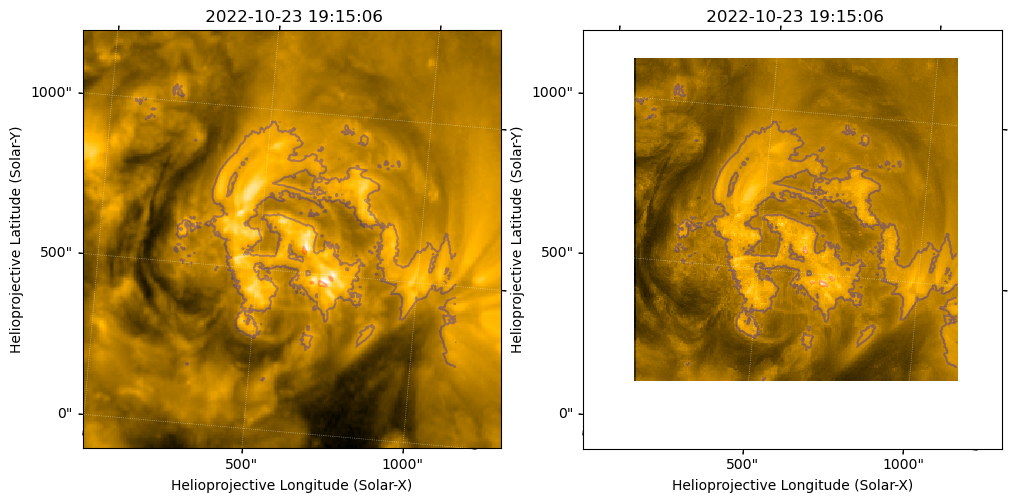

In [15]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=fsi_174_crop)
im1 = fsi_174_crop.plot()

ax2 = fig.add_subplot(122,projection=hri_174_map_repro)
im2 = hri_174_map_repro.plot()

hri_levels = [1000,5000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    hri_174_map_repro.draw_contours(hri_levels,colors=["b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)


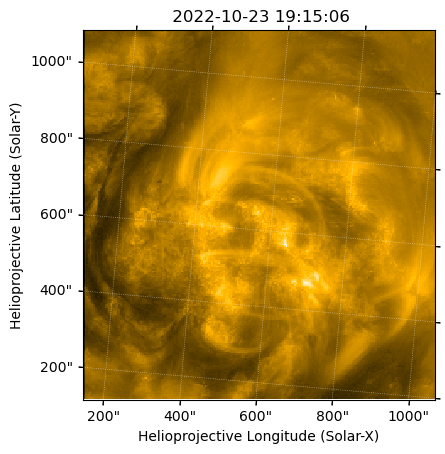

In [21]:
hri_174_map_repro_cut = hri_174_map_repro.submap([36,47]*u.pix,
                                                 top_right=[244,265]*u.pix)
hri_174_map_repro_cut.plot()

In [22]:
Txshift_hri, Tyshift_hri = coalign_shift(fsi_174_crop,hri_174_map_repro_cut)
print(Txshift_hri, Tyshift_hri)

4.26535 arcsec 7.96536 arcsec


In [23]:
hri_174_map_repro_shift = hri_174_map_repro.shift_reference_coord(Txshift_hri,Tyshift_hri)
hri_174_map_repro_cut_shift = hri_174_map_repro_cut.shift_reference_coord(Txshift_hri,Tyshift_hri)
hri_174_map_shifted = hri_174_map.shift_reference_coord(Txshift_hri,Tyshift_hri)
# hri_174_map_shifted = hri_174_map_shifted.submap([10,10]*u.pix,
#                                                     top_right=[2038,2038]*u.pix)
fsi_174_hri_fov = fsi_174_map_hri_time.reproject_to(hri_174_map_shifted.wcs)

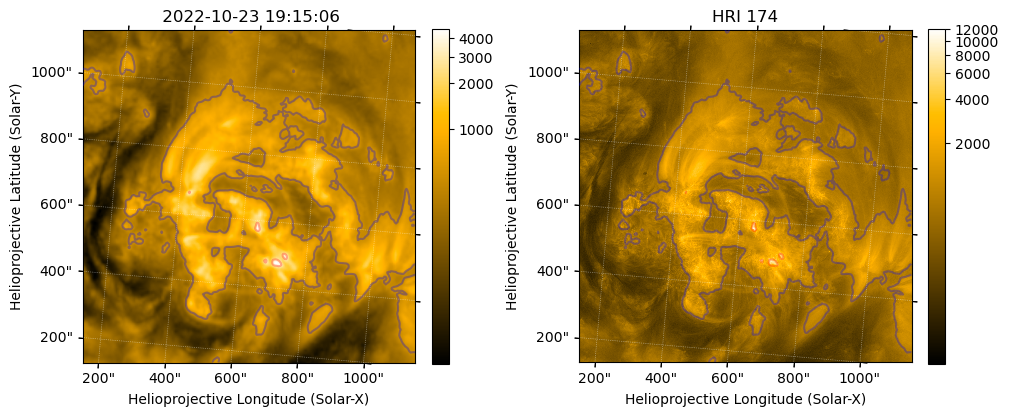

In [24]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=fsi_174_hri_fov)
im1 = fsi_174_hri_fov.plot()
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=hri_174_map_shifted)
im2 = hri_174_map_shifted.plot()
ax2.set_title("HRI 174")
plt.colorbar(ax=ax2,shrink=0.75)

fsi_174_levels = [500,3000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    fsi_174_hri_fov.draw_contours(fsi_174_levels,colors=["b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)

In [25]:
SunBlinker(fsi_174_hri_fov, hri_174_map_shifted)

In [26]:
fsi_304_map_hri_time = derotate_fsi(fsi_304_map,hri_174_map)

In [27]:
fsi_304_crop = fsi_304_map_hri_time.submap(SkyCoord(0*u.arcsec,0*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1200*u.arcsec,1200*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame))

In [28]:
SunBlinker(fsi_174_crop, fsi_304_crop)

In [29]:
aia_304_map_repro = aia_304_map.reproject_to(fsi_304_crop.wcs)

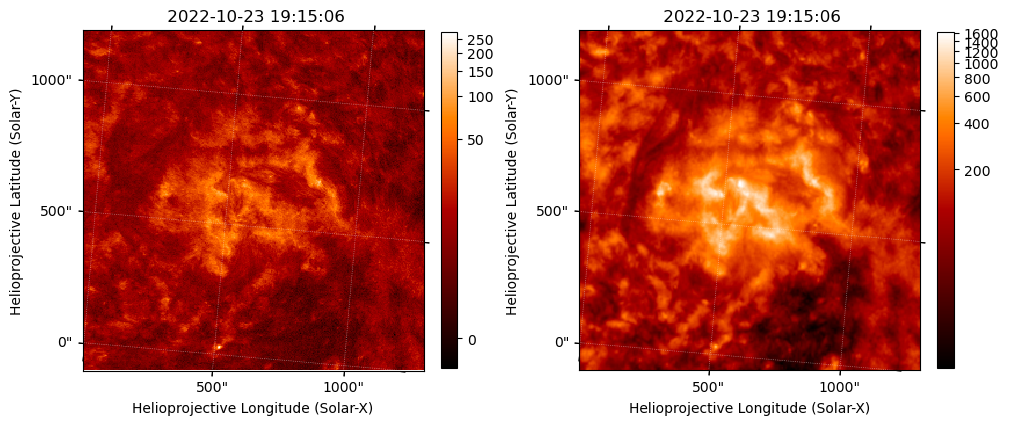

In [30]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_repro)
im1 = aia_304_map_repro.plot()
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=fsi_304_crop)
im2 = fsi_304_crop.plot()
plt.colorbar(ax=ax2,shrink=0.75)

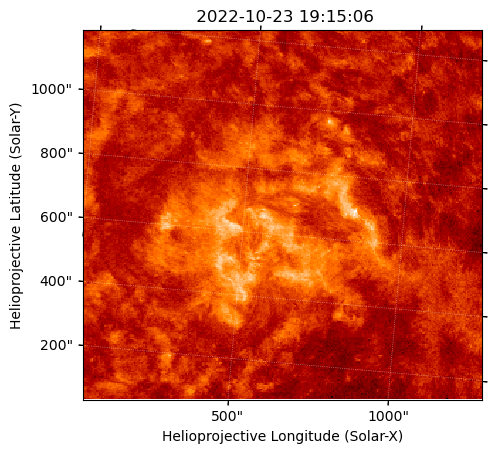

In [33]:
aia_304_map_repro_cut = aia_304_map_repro.submap([12,30]*u.pix,
                                                    top_right=[325,290]*u.pix)
aia_304_map_repro_cut.plot()

In [35]:
Txshift_aia_fsi, Tyshift_aia_fsi = coalign_shift(fsi_304_crop,aia_304_map_repro_cut)
print(Txshift_aia_fsi, Tyshift_aia_fsi)

-0.334497 arcsec 3.79503 arcsec


In [36]:
fsi_304_crop_shift = fsi_304_crop.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
fsi_174_crop_shift = fsi_174_crop.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
hri_174_map_shifted_toaia = hri_174_map_shifted.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
fsi_304_map_hri_time_shift = fsi_304_map_hri_time.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
fsi_174_map_hri_time_shift = fsi_174_map_hri_time.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)

In [37]:
fsi_174_map_hri_time_shift.meta["obsrvtry"] = fsi_174_map.meta["obsrvtry"]
fsi_174_map_hri_time_shift.meta["telescop"] = fsi_174_map.meta["telescop"]
fsi_174_map_hri_time_shift.meta["instrume"] = fsi_174_map.meta["instrume"]
fsi_174_map_hri_time_shift.meta["detector"] = fsi_174_map.meta["detector"]
fsi_174_map_hri_time_shift.meta["wavelnth"] = fsi_174_map.meta["wavelnth"]
fsi_174_map_hri_time_shift.meta["waveunit"] = fsi_174_map.meta["waveunit"]

In [38]:
fsi_174_map_hri_time_shift.save("../../src/coalign_map/20221023/fsi_174_map_hri_time_shift.fits",overwrite=True)

In [39]:
hri_174_map_shifted_toaia.save("../../src/coalign_map/20221023/hri_174_map_shifted_toaia.fits",overwrite=True)
fsi_304_map_hri_time_shift.save("../../src/coalign_map/20221023/fsi_304_map_hri_time_shift.fits",overwrite=True)

In [40]:
# 
def reproject_to_above_surface(map,target_wcs,radius=None,height=None):
    if radius is None and height is not None:
        rsun_ref = map.meta["rsun_ref"] + height.to_value(u.m)
    elif radius is not None and height is None:
        rsun_ref = radius.to_value(u.m)
    else:
        rsun_ref = map.meta["rsun_ref"]

    map_new = deepcopy(map)
    target_wcs_new = deepcopy(target_wcs)

    map_new.meta["rsun_ref"] = rsun_ref
    target_wcs_new.wcs.aux.rsun_ref = rsun_ref

    return map_new.reproject_to(target_wcs_new)

In [41]:
aia_171_repro_hrifov_2dot8 = reproject_to_above_surface(aia_171_map,hri_174_map_shifted_toaia.wcs,height=2.8*u.Mm)

In [42]:
SunBlinker(aia_171_repro_hrifov_2dot8, hri_174_map_shifted_toaia)

In [44]:
hmi_los_map_to_aia = sunpy.map.Map("../../src/HMI/20221023/lvl15/hmi.M_45s.20221023_192100_TAI.2.magnetogram.fits")

In [45]:
hmi_los_map_repro = hmi_los_map_to_aia.reproject_to(fsi_304_crop_shift.wcs)
hmi_los_map_repro_hrifov = hmi_los_map_to_aia.reproject_to(hri_174_map_shifted_toaia.wcs)

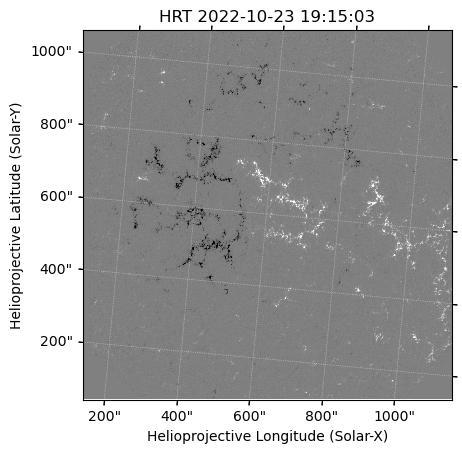

In [47]:
phi_los_map = sunpy.map.Map("../../src/PHI/20221023/solo_L2_phi-hrt-blos_20221023T191503_V01.fits")
phi_los_map.meta["rsun_ref"] = 696000000.
phi_los_map.plot_settings['norm'] = plt.Normalize(-500, 500)
phi_los_map.plot()

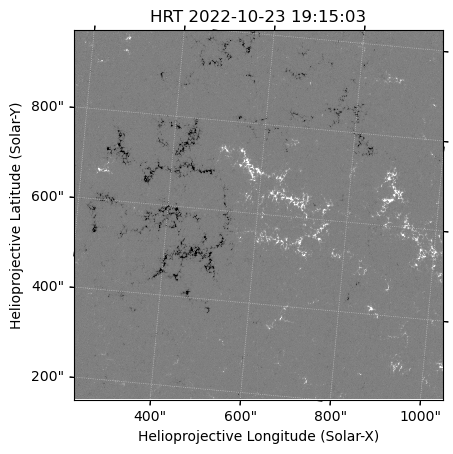

In [48]:
phi_los_map_crop = phi_los_map.submap([200,200]*u.pix,
                                      top_right=[1847,1847]*u.pix)

phi_los_map_crop.plot()

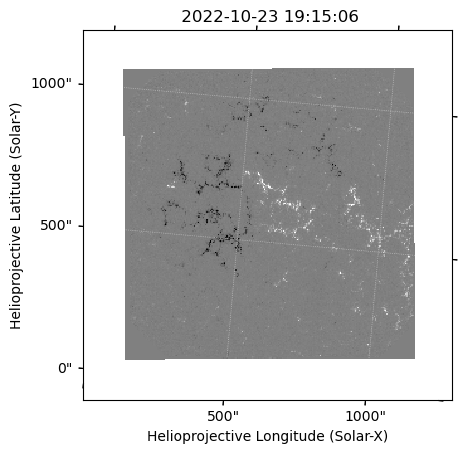

In [49]:
phi_los_map_resample = phi_los_map.reproject_to(fsi_304_crop_shift.wcs)
phi_los_map_resample.plot()

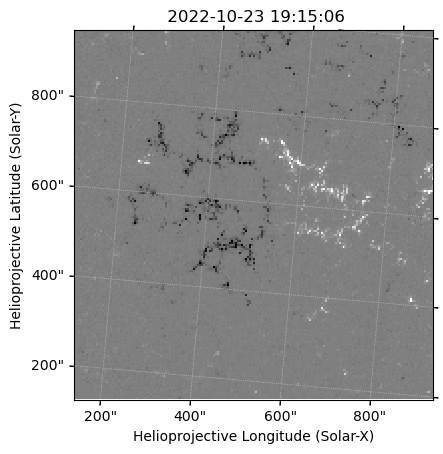

In [53]:
phi_los_map_resample_crop = phi_los_map_resample.submap([35,50]*u.pix,
                                                        top_right=[215,235]*u.pix)
phi_los_map_resample_crop.plot()

In [54]:
Txshift_phi_hmi, Tyshift_phi_hmi = coalign_shift(hmi_los_map_repro,phi_los_map_resample_crop)
print(Txshift_phi_hmi, Tyshift_phi_hmi)

4.40954 arcsec -71.2679 arcsec


In [55]:
phi_los_map_shifted = phi_los_map.shift_reference_coord(Txshift_phi_hmi,Tyshift_phi_hmi)
phi_los_map_shifted_hrifov = phi_los_map_shifted.reproject_to(hri_174_map_shifted_toaia.wcs)
phi_los_map_resample_crop_shifted = phi_los_map_resample_crop.shift_reference_coord(Txshift_phi_hmi,Tyshift_phi_hmi)

In [56]:
phi_los_map_shifted.save("../../src/coalign_map/20221023/phi_los_map_shifted.fits",overwrite=True)

In [59]:
SunBlinker(phi_los_map_shifted, hmi_los_map_to_aia, reproject=True, fps=1,
           norm1=plt.Normalize(-500, 500), norm2=plt.Normalize(-500, 500))